In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.config.list_physical_devices('GPU'))

[]


In [35]:
# Constants
BATCH_SIZE = 32
LR = 1e-6

In [36]:
df = pd.read_csv('champions.csv')
def get_champ_vec(champ_name):
    arr = []
    row = df.loc[df['Champion'] == champ_name].iloc[0]
    for i in range(1, 16):
        if i == 7:
            if row[i] == 1:
                arr.append(1)
                arr.append(0)
                arr.append(0)
            elif row[i] == 2:
                arr.append(0)
                arr.append(1)
                arr.append(0)
            elif row[i] == 3:
                arr.append(0)
                arr.append(0)
                arr.append(1)
        else:
            arr.append(row[i] / 10)
    return arr

In [37]:
def process_match(match):
        champs = match.split(',')
        vec = []
        for i in range(10):
            champ_vec = get_champ_vec(champs[i])
            for e in champ_vec:
                vec.append(e)
        if champs[10] == 'true':
            vec.append(1)
        else:
            vec.append(0)
        return vec

In [38]:
def process_ds_element(x):
    return (tf.cast(x[:-1], 'float32'), tf.cast(x[-1], 'float32'))

In [39]:
def get_dataset():
    tmp = []
    with open('data/matches/training_data.txt', 'r') as f:
        matches = f.read().split('\n')
        global NUM_GAMES
        NUM_GAMES = len(matches)
        for match in matches:
            try:
                tmp.append(process_match(match))
            except:
                NUM_GAMES-=1
    ds = tf.data.Dataset.from_tensor_slices(tmp)
    ds = ds.map(process_ds_element)
    ds = ds.cache()
    ds = ds.shuffle(NUM_GAMES)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    print(f'Using {NUM_GAMES} matches for training')
    return ds

In [40]:
ds = get_dataset()

Using 149980 matches for training


In [41]:
# Partition Dataset
train_size = int(len(ds)*0.7)
val_size = int(len(ds)*0.2)
test_size = len(ds) - (train_size + val_size)

train = ds.take(train_size)
val = ds.skip(train_size).take(val_size)
test = ds.skip(train_size+val_size).take(test_size)

In [42]:
print(train_size, val_size, test_size)

3280 937 470


In [43]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(170, activation='relu', input_dim=170))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    return model

In [44]:
model = create_model()

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 170)               29070     
                                                                 
 dense_1 (Dense)             (None, 64)                10944     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 41,071
Trainable params: 41,071
Non-trainable params: 0
_________________________________________________________________


In [46]:
loss = losses.BinaryCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=LR)

In [47]:
model.compile(loss=loss, optimizer=optimizer, metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

In [48]:
history = model.fit(train, validation_data=val, epochs=100)

Epoch 1/100
3280/3280 [==============================] - 5s 943us/step - loss: 0.6965 - binary_accuracy: 0.5070 - val_loss: 0.6947 - val_binary_accuracy: 0.5087
Epoch 2/100
3280/3280 [==============================] - 3s 903us/step - loss: 0.6946 - binary_accuracy: 0.5038 - val_loss: 0.6946 - val_binary_accuracy: 0.5014
Epoch 3/100
3280/3280 [==============================] - 3s 902us/step - loss: 0.6944 - binary_accuracy: 0.5026 - val_loss: 0.6950 - val_binary_accuracy: 0.4997
Epoch 4/100
3280/3280 [==============================] - 3s 903us/step - loss: 0.6946 - binary_accuracy: 0.5020 - val_loss: 0.6946 - val_binary_accuracy: 0.5011
Epoch 5/100
3280/3280 [==============================] - 3s 915us/step - loss: 0.6944 - binary_accuracy: 0.5021 - val_loss: 0.6942 - val_binary_accuracy: 0.5015
Epoch 6/100
3280/3280 [==============================] - 3s 910us/step - loss: 0.6940 - binary_accuracy: 0.5046 - val_loss: 0.6941 - val_binary_accuracy: 0.5066
Epoch 7/100
3280/3280 [===========

In [49]:
history_dict = history.history

In [50]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

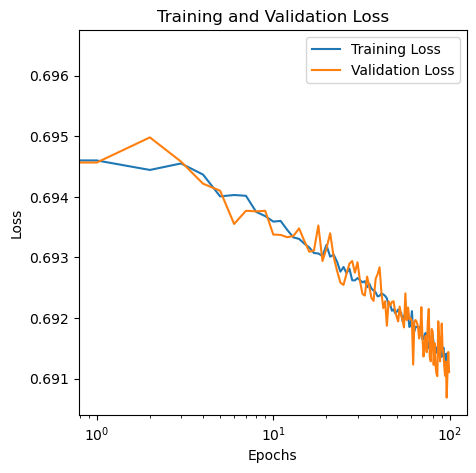

In [51]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

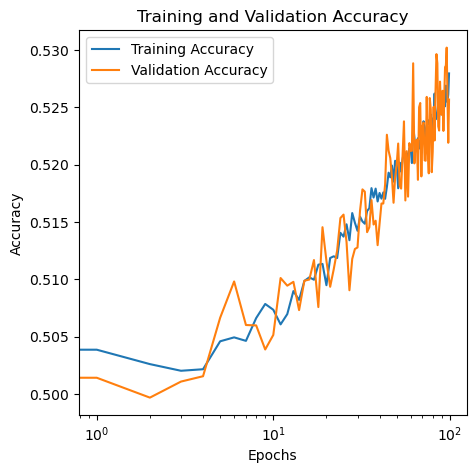

In [52]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
loss, accuracy = model.evaluate(test)
print('Loss:', loss)
print('Accuracy:', accuracy)

470/470 [==============================] - 1s 2ms/step - loss: 0.6913 - binary_accuracy: 0.5259
Loss: 0.6913020610809326
Accuracy: 0.5259062051773071


In [ ]:
# Save the model
model.save('win_predictor.h5')